In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as kb
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
data = pd.read_csv('../input/eeg-brainwave-dataset-feeling-emotions/emotions.csv')
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [17]:
len(data)

2132

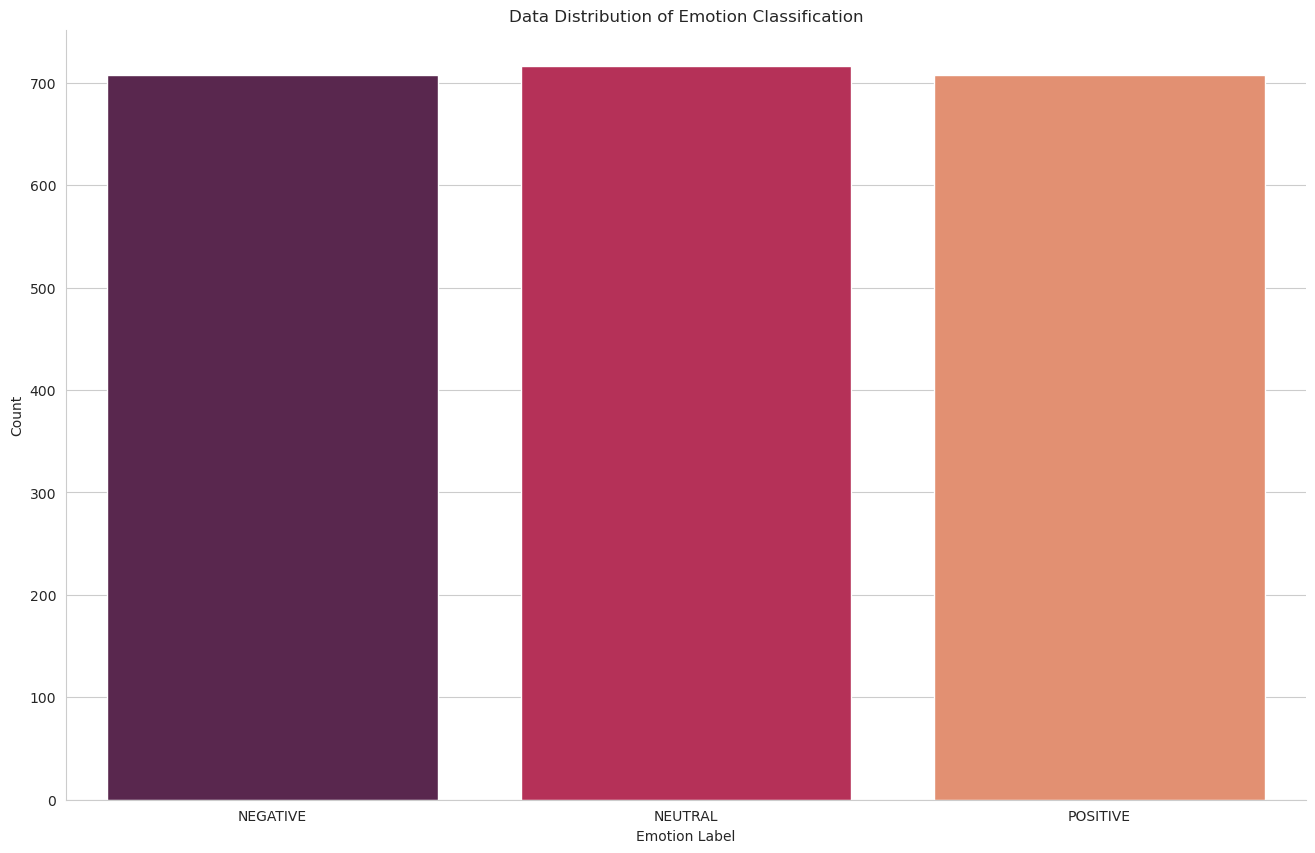

In [68]:
# visualization of data distribution
plt.figure(figsize = (16, 10))
sns.set_style("whitegrid")
sns.countplot(x = 'label', data = data, palette = "rocket")
plt.title("Data Distribution of Emotion Classification")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
sns.despine(top = True, right = True)
plt.show()

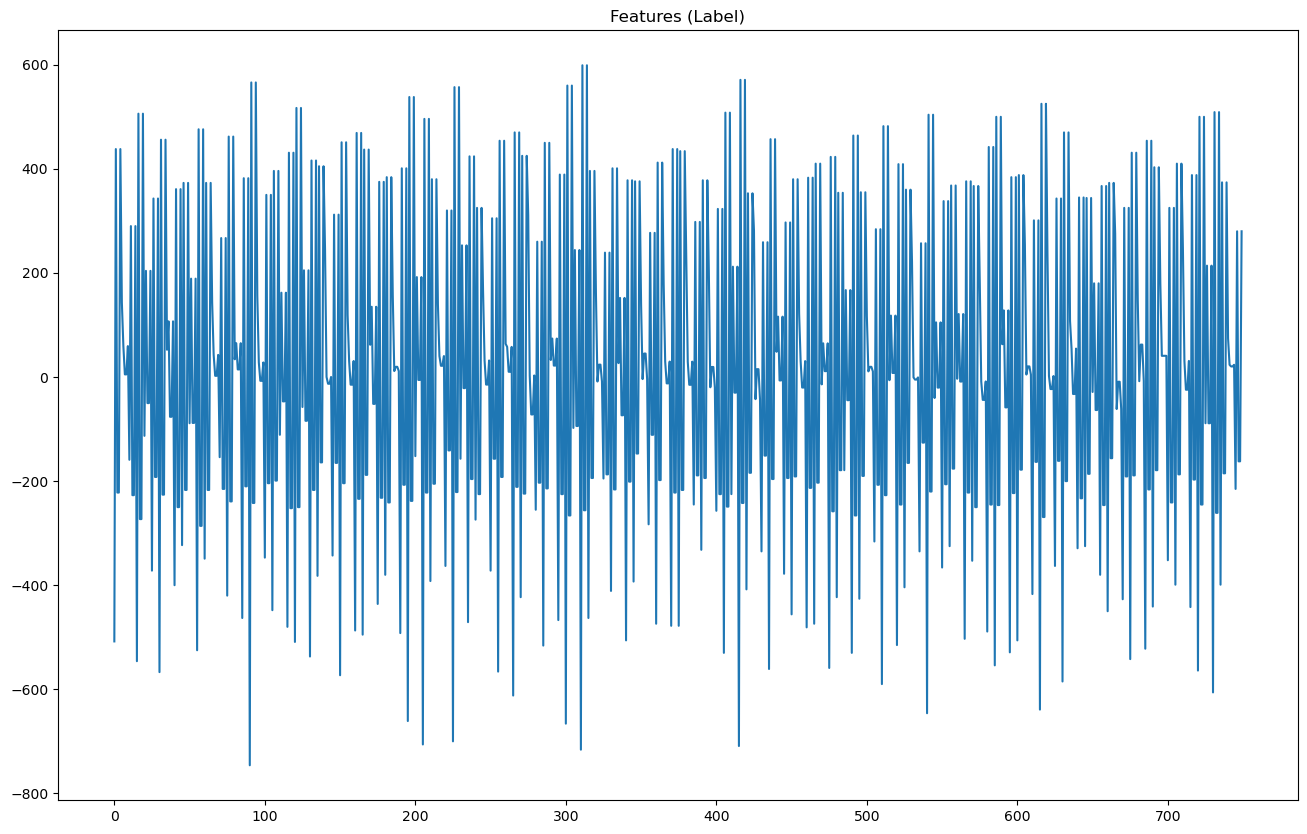

In [19]:
sample = data.loc[0, 'fft_0_b':'fft_749_b']

plt.figure(figsize=(16, 10))
plt.plot(range(len(sample)), sample)
plt.title("Features (Label)")
plt.show()

In [20]:
data['label'].value_counts()

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [28]:
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}

In [37]:
def preprocess(df, test_size=0.2, random_state=None):
    # map the labels using a dictionary comprehension
    label_mapping = {'neutral': 1, 'positive': 2, 'negative': 0}
    df['label'] = df['label'].map(label_mapping)

    # split the data into training and test sets
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    return X_train, X_test, y_train, y_test

In [38]:
X_train, X_test, y_train, y_test = preprocess(data)
X_train.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
993,14.400,29.7,-112.0,18.5,22.9,-3.63000,-2.2200,-2.180,-3.240,-4.04,...,-50.0,150.0,-150.0,-150.0,150.0,63.6,83.80,-40.90,-40.90,83.80
1851,13.700,22.8,21.5,8.4,27.1,3.27000,1.1200,6.480,2.300,5.66,...,74.2,-76.0,-10.9,-10.9,-76.0,60.9,-60.40,-31.40,-31.40,-60.40
1253,-0.765,24.7,-578.0,11.9,27.9,-1.44000,-4.2000,-8.310,-4.340,4.04,...,-803.0,619.0,-331.0,-331.0,619.0,-551.0,545.00,-261.00,-261.00,545.00
1228,28.200,32.6,32.1,30.3,24.6,-0.00524,-0.0699,1.680,0.266,-4.47,...,167.0,-24.4,-18.1,-18.1,-24.4,181.0,4.94,-8.33,-8.33,4.94
1461,31.900,31.0,34.4,30.8,24.0,-4.74000,-1.4000,-0.351,-1.830,-5.39,...,130.0,-25.7,4.1,4.1,-25.7,131.0,-21.70,19.60,19.60,-21.70


In [55]:
inputs = tf.keras.Input(shape = (X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis = 2)

lstm1 = tf.keras.layers.LSTM(128, return_sequences = True)(expand_dims)
dropout1 = tf.keras.layers.Dropout(0.2)(lstm1)

lstm2 = tf.keras.layers.LSTM(64, return_sequences = True)(dropout1)
dropout2 = tf.keras.layers.Dropout(0.2)(lstm2)

flatten = tf.keras.layers.Flatten()(dropout2)

dense1 = tf.keras.layers.Dense(64, activation = 'relu')(flatten)
dropout3 = tf.keras.layers.Dropout(0.2)(dense1)

dense2 = tf.keras.layers.Dense(32, activation = 'relu')(dropout3)
dropout4 = tf.keras.layers.Dropout(0.2)(dense2)

outputs = tf.keras.layers.Dense(3, activation = 'softmax')(dropout4)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

print(model.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 2548)]            0         
                                                                 
 tf.expand_dims_10 (TFOpLamb  (None, 2548, 1)          0         
 da)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 2548, 128)         66560     
                                                                 
 dropout_12 (Dropout)        (None, 2548, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 2548, 64)          49408     
                                                                 
 dropout_13 (Dropout)        (None, 2548, 64)          0         
                                                          

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer = optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    batch_size = 32,
    epochs = 50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor = 'val_loss',
            patience = 5,
            restore_best_weights = True
        )
    ]
)

Epoch 1/50
38/38 [==============================] - 12s 199ms/step - loss: 1.2340 - accuracy: 0.7393 - val_loss: 0.3349 - val_accuracy: 0.8997
Epoch 2/50
38/38 [==============================] - 7s 185ms/step - loss: 0.3699 - accuracy: 0.8667 - val_loss: 0.2631 - val_accuracy: 0.8930
Epoch 3/50
38/38 [==============================] - 7s 180ms/step - loss: 0.2493 - accuracy: 0.8944 - val_loss: 0.2102 - val_accuracy: 0.9164
Epoch 4/50
38/38 [==============================] - 7s 177ms/step - loss: 0.1984 - accuracy: 0.9204 - val_loss: 0.2465 - val_accuracy: 0.9197
Epoch 5/50
38/38 [==============================] - 7s 176ms/step - loss: 0.1418 - accuracy: 0.9547 - val_loss: 0.1528 - val_accuracy: 0.9465
Epoch 6/50
38/38 [==============================] - 7s 188ms/step - loss: 0.1024 - accuracy: 0.9598 - val_loss: 0.1342 - val_accuracy: 0.9532
Epoch 7/50
38/38 [==============================] - 7s 175ms/step - loss: 0.0776 - accuracy: 0.9799 - val_loss: 0.1226 - val_accuracy: 0.9599
Epoch

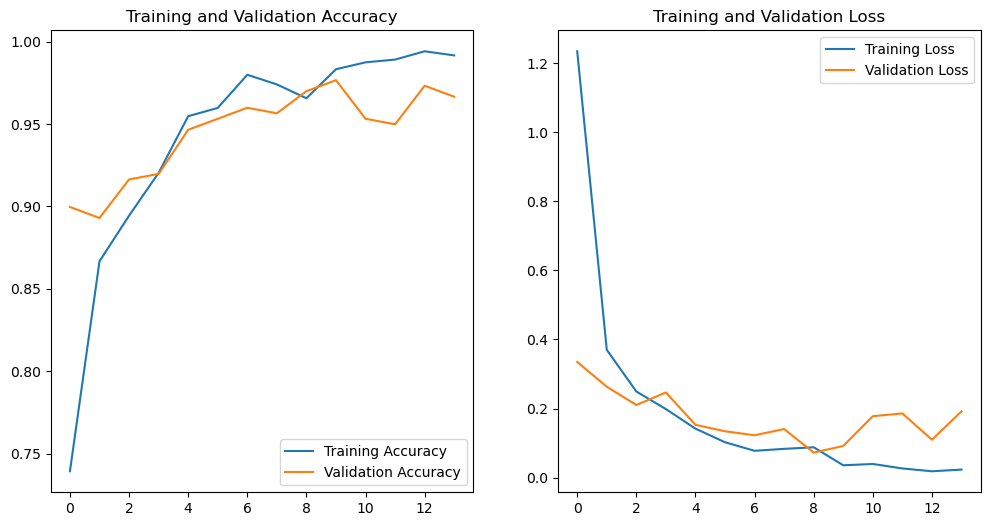

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [59]:
model_accuracy = model.evaluate(X_test, y_test, verbose = 0)[1]
print("Test Accuracy: {:.3f}%".format(model_accuracy * 100))

Test Accuracy: 96.719%


20/20 [==============================] - 2s 72ms/step


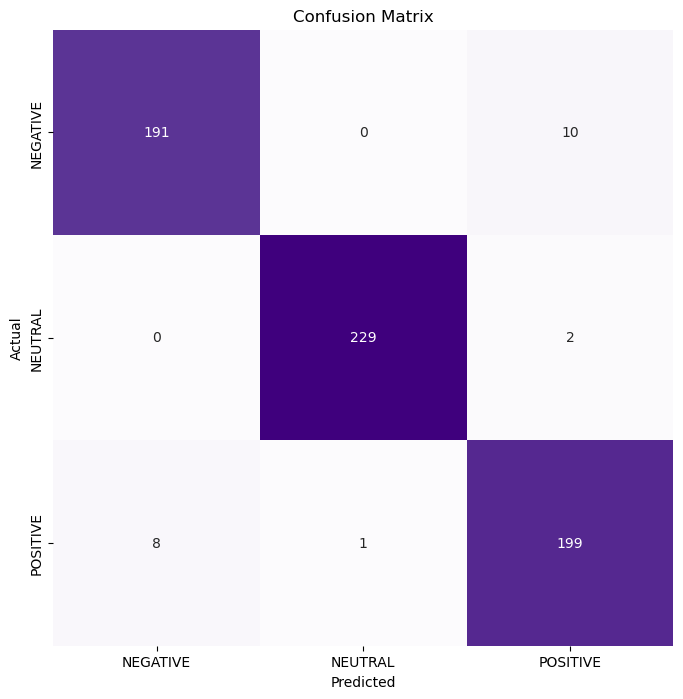

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.96      0.95      0.96       201
     NEUTRAL       1.00      0.99      0.99       231
    POSITIVE       0.94      0.96      0.95       208

    accuracy                           0.97       640
   macro avg       0.97      0.97      0.97       640
weighted avg       0.97      0.97      0.97       640



In [65]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot = True, vmin = 0, fmt = 'g', cbar = False, cmap = 'Purples')
plt.xticks(np.arange(3) + 0.5, label_mapping.keys())
plt.yticks(np.arange(3) + 0.5, label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)
